# Implementation of DDPM paper in Pytorch

<p align="center">
<img src='https://drive.google.com/uc?id=11C3cBUfz7_vrkj_4CWCyePaQyr-0m85_' width=500>
</p>

In [1]:
# Import functions

!pip install -q -U einops &> /dev/null

import numpy as np
import math
from inspect import isfunction
from functools import partial
from tqdm import tqdm


import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from einops import rearrange

import torch
from torch import nn, einsum
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset

In [2]:
# Connect to drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
cd /content/gdrive/.shortcut-targets-by-id/1nxP_Htk3Zxd5HNqy4vwS13iMDyVJoASy/Final Project - Diffusion Models

/content/gdrive/.shortcut-targets-by-id/1nxP_Htk3Zxd5HNqy4vwS13iMDyVJoASy/Final Project - Diffusion Models


## Architecture - UNet

### Network helpers

In [4]:
def exists(x):
    return x is not None

def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x

def Upsample(dim):
    return nn.ConvTranspose2d(dim, dim, 4, 2, 1)

def Downsample(dim):
    return nn.Conv2d(dim, dim, 4, 2, 1)

### Position embeddings

In [5]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

### ResNet/ConvNeXT block


In [6]:
class Block(nn.Module):
    def __init__(self, dim, dim_out, groups = 8):
        super().__init__()
        self.proj = nn.Conv2d(dim, dim_out, 3, padding = 1)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(self, x, scale_shift = None):
        x = self.proj(x)
        x = self.norm(x)

        if exists(scale_shift):
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.act(x)
        return x

class ResnetBlock(nn.Module):
    
    def __init__(self, dim, dim_out, *, time_emb_dim=None, groups=8):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.SiLU(), nn.Linear(time_emb_dim, dim_out))
            if exists(time_emb_dim)
            else None
        )

        self.block1 = Block(dim, dim_out, groups=groups)
        self.block2 = Block(dim_out, dim_out, groups=groups)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        h = self.block1(x)

        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            h = rearrange(time_emb, "b c -> b c 1 1") + h

        h = self.block2(h)
        return h + self.res_conv(x)
    
class ConvNextBlock(nn.Module):

    def __init__(self, dim, dim_out, *, time_emb_dim=None, mult=2, norm=True):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.GELU(), nn.Linear(time_emb_dim, dim))
            if exists(time_emb_dim)
            else None
        )

        self.ds_conv = nn.Conv2d(dim, dim, 7, padding=3, groups=dim)

        self.net = nn.Sequential(
            nn.GroupNorm(1, dim) if norm else nn.Identity(),
            nn.Conv2d(dim, dim_out * mult, 3, padding=1),
            nn.GELU(),
            nn.GroupNorm(1, dim_out * mult),
            nn.Conv2d(dim_out * mult, dim_out, 3, padding=1),
        )

        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        h = self.ds_conv(x)

        if exists(self.mlp) and exists(time_emb):
            assert exists(time_emb), "time embedding must be passed in"
            condition = self.mlp(time_emb)
            h = h + rearrange(condition, "b c -> b c 1 1")

        h = self.net(h)
        return h + self.res_conv(x)

### Attention module

In [7]:
class Attention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )
        q = q * self.scale

        sim = einsum("b h d i, b h d j -> b h i j", q, k)
        sim = sim - sim.amax(dim=-1, keepdim=True).detach()
        attn = sim.softmax(dim=-1)

        out = einsum("b h i j, b h d j -> b h i d", attn, v)
        out = rearrange(out, "b h (x y) d -> b (h d) x y", x=h, y=w)
        return self.to_out(out)

class LinearAttention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)

        self.to_out = nn.Sequential(nn.Conv2d(hidden_dim, dim, 1), 
                                    nn.GroupNorm(1, dim))

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )

        q = q.softmax(dim=-2)
        k = k.softmax(dim=-1)

        q = q * self.scale
        context = torch.einsum("b h d n, b h e n -> b h d e", k, v)

        out = torch.einsum("b h d e, b h d n -> b h e n", context, q)
        out = rearrange(out, "b h c (x y) -> b (h c) x y", h=self.heads, x=h, y=w)
        return self.to_out(out)

### Group normalization

In [8]:
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.GroupNorm(1, dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)

### Conditional U-Net
- the network takes a batch of noisy images of shape `(batch_size, num_channels, height, width)` and a batch of noise levels of shape `(batch_size, 1)` as input, and returns a tensor of shape `(batch_size, num_channels, height, width)`

The network is built up as follows:
* first, a convolutional layer is applied on the batch of noisy images, and position embeddings are computed for the noise levels
* next, a sequence of downsampling stages are applied. Each downsampling stage consists of 2 ResNet/ConvNeXT blocks + groupnorm + attention + residual connection + a downsample operation
* at the middle of the network, again ResNet or ConvNeXT blocks are applied, interleaved with attention
* next, a sequence of upsampling stages are applied. Each upsampling stage consists of 2 ResNet/ConvNeXT blocks + groupnorm + attention + residual connection + an upsample operation
* finally, a ResNet/ConvNeXT block followed by a convolutional layer is applied.


In [9]:
class Unet(nn.Module):
    def __init__(
        self,
        dim,
        init_dim=None,
        out_dim=None,
        dim_mults=(1, 2, 4, 8),
        channels=3,
        with_time_emb=True,
        resnet_block_groups=8,
        use_convnext=True,
        convnext_mult=2,
    ):
        super().__init__()

        # determine dimensions
        self.channels = channels

        init_dim = default(init_dim, dim // 3 * 2)
        self.init_conv = nn.Conv2d(channels, init_dim, 7, padding=3)

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))
        
        if use_convnext:
            block_klass = partial(ConvNextBlock, mult=convnext_mult)
        else:
            block_klass = partial(ResnetBlock, groups=resnet_block_groups)

        # time embeddings
        if with_time_emb:
            time_dim = dim * 4
            self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(dim),
                nn.Linear(dim, time_dim),
                nn.GELU(),
                nn.Linear(time_dim, time_dim),
            )
        else:
            time_dim = None
            self.time_mlp = None

        # layers
        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(
                nn.ModuleList(
                    [
                        block_klass(dim_in, dim_out, time_emb_dim=time_dim),
                        block_klass(dim_out, dim_out, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                        Downsample(dim_out) if not is_last else nn.Identity(),
                    ]
                )
            )

        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
            is_last = ind >= (num_resolutions - 1)

            self.ups.append(
                nn.ModuleList(
                    [
                        block_klass(dim_out * 2, dim_in, time_emb_dim=time_dim),
                        block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                        Upsample(dim_in) if not is_last else nn.Identity(),
                    ]
                )
            )

        out_dim = default(out_dim, channels)
        self.final_conv = nn.Sequential(
            block_klass(dim, dim), nn.Conv2d(dim, out_dim, 1)
        )

    def forward(self, x, time):
        x = self.init_conv(x)

        t = self.time_mlp(time) if exists(self.time_mlp) else None

        h = []

        # downsample
        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            h.append(x)
            x = downsample(x)

        # bottleneck
        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        # upsample
        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim=1)
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            x = upsample(x)

        return self.final_conv(x)

## Forward Diffusion Process

In [10]:
# Different types of schedules for Variance beta_t

def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule as proposed in Nichol et
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)

def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

def quadratic_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start**0.5, beta_end**0.5, timesteps) ** 2

def sigmoid_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    betas = torch.linspace(-6, 6, timesteps)
    return torch.sigmoid(betas) * (beta_end - beta_start) + beta_start

In [11]:
class Diffusion:

  def __init__(self, schedule, timesteps, loss_type):

    self.loss_type = loss_type
    self.timesteps = timesteps

    # define beta schedule
    self.betas = schedule(timesteps=timesteps)

    # define alphas 
    self.alphas = 1. - self.betas
    self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
    self.alphas_cumprod_prev = F.pad(self.alphas_cumprod[:-1], (1, 0), value=1.0)

    # calculations for diffusion q(x_t | x_{t-1}) and others
    self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
    self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - self.alphas_cumprod)
    self.sqrt_recip_alphas = torch.sqrt(1.0 / self.alphas)

    # calculations for posterior q(x_{t-1} | x_t, x_0) - beta~ 
    self.posterior_variance = self.betas * (1. - self.alphas_cumprod_prev) / (1. - self.alphas_cumprod)


  def extract(self, a, t, x_shape):
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)


  def q_sample(self, x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)

    sqrt_alphas_cumprod_t = self.extract(self.sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = self.extract(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape)
    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise


  def loss_func(self, denoise_model, x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)

    x_t = self.q_sample(x_start=x_start, t=t, noise=noise)
    predicted_noise = denoise_model(x_t, t)

    if self.loss_type == 'l1':
        loss = F.l1_loss(noise, predicted_noise)
    elif self.loss_type == 'l2':
        loss = F.mse_loss(noise, predicted_noise)
    elif self.loss_type == "huber":
        loss = F.smooth_l1_loss(noise, predicted_noise)
    else:
        raise NotImplementedError()

    return loss


  @torch.no_grad()
  def p_sample(self, model, x, t, t_index):
      betas_t = self.extract(self.betas, t, x.shape)
      sqrt_one_minus_alphas_cumprod_t = self.extract(self.sqrt_one_minus_alphas_cumprod, t, x.shape)
      sqrt_recip_alphas_t = self.extract(self.sqrt_recip_alphas, t, x.shape)
      
      # Use our model (noise predictor) to predict the mean
      model_mean = sqrt_recip_alphas_t * (x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t)

      if t_index == 0:
          return model_mean
      else:
          posterior_variance_t = self.extract(self.posterior_variance, t, x.shape)
          noise = torch.randn_like(x)
          return model_mean + torch.sqrt(posterior_variance_t) * noise 


  @torch.no_grad()
  def p_sample_loop(self, model, shape):
      device = next(model.parameters()).device

      b = shape[0]
      # start from pure noise (for each example in the batch)
      img = torch.randn(shape, device=device)
      
      for i in tqdm(reversed(range(0, self.timesteps)), desc='sampling loop time step', total=self.timesteps):
          img = self.p_sample(model, img, torch.full((b,), i, device=device, dtype=torch.long), i)
          if i==0:
            gen_img = img.cpu()
      return gen_img

  @torch.no_grad()
  def sample(self, model, image_size, batch_size=16, channels=3):
      return self.p_sample_loop(model, shape=(batch_size, channels, image_size, image_size))

## Training

### Loading the dataset

In [12]:
train_dataset = datasets.FashionMNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.FashionMNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

train_batch_size = 128
test_batch_size = 128

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=train_batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=test_batch_size, shuffle=False)

### Train

In [13]:
from inception_score import inception_score
import warnings
warnings.filterwarnings("ignore")

def train(num_epochs, diffusion_model, timesteps, load=False, path=None, plot=True, name='0', eval=False):

    device = "cuda" if torch.cuda.is_available() else "cpu"

    model = Unet(
        dim=28,
        channels=1,
        dim_mults=(1, 2, 4,)
    )
    model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=1e-3)
  
    loss_list = []

    start = 0
    if load:
        print("Loading checkpoint.....")
        checkpoint = torch.load(path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch_load = checkpoint['epoch']
        loss = checkpoint['loss']
        print("Checkpoint loaded at epoch {} and loss {}".format(epoch_load, loss))
        start = epoch_load

    for epoch in range(start, num_epochs):
        with tqdm(train_loader, unit="batch") as tepoch:

          # Training phase
          model.train()
          running_loss = 0.

          for batch_idx, (data, _) in enumerate(tepoch):
            optimizer.zero_grad()

            data = data.to(device)

            # sample t uniformally for every example in the batch
            t = torch.randint(0, timesteps, (data.shape[0],), device=device).long()

            # Compute loss using the current model
            loss = diffusion_model.loss_func(model, data, t)
            running_loss += loss.item()

            loss.backward()
            optimizer.step()

        # Create Checkpoint
        full_loss = running_loss/len(train_loader)
        loss_list.append(full_loss)

        print('Epoch: {}, Loss: {:.4f}'.format(epoch+1, full_loss))

    path = 'model/model_checkpoint_'+name+ '.pth'
    torch.save({
        'epoch': epoch+1,
        'model_state_dict': model.state_dict(),
        'loss': full_loss,
        }, path)
        
    if(plot):
      plt.title("Diffusion Loss")
      plt.plot(loss_list,label="train loss")
      plt.xlabel("Epochs")
      plt.ylabel("Loss")
      plt.legend()
      plt.show()

    if(eval):
      print("\n Evaluating...")
      model.eval()
      evaluate_num = 1000
      gen_set = []

      with torch.no_grad():
          fake_batch = diffusion_model.sample(model, image_size=28, batch_size=evaluate_num, channels=1)
        
          for i in range(evaluate_num):
            gen_image = fake_batch[i].cpu().detach()
            gen_image = gen_image.reshape(-1,28,28).unsqueeze(0)
            gen_image = gen_image.repeat(1,3,1,1)
            gen_set.append(gen_image)

      gen_set = TensorDataset(torch.cat(gen_set))
      
      print('generated images IS_score:')
      print(inception_score(gen_set, cuda=True, batch_size=64, resize=True, splits=1))


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 1, Loss: 0.0791


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 2, Loss: 0.0184


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 3, Loss: 0.0153


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 4, Loss: 0.0141


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 5, Loss: 0.0135


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 6, Loss: 0.0131


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 7, Loss: 0.0125


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 8, Loss: 0.0125


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 9, Loss: 0.0123


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 10, Loss: 0.0121


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 11, Loss: 0.0121


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 12, Loss: 0.0120


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 13, Loss: 0.0118


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 14, Loss: 0.0116


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 15, Loss: 0.0116


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 16, Loss: 0.0116


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 17, Loss: 0.0114


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 18, Loss: 0.0113


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 19, Loss: 0.0112


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 20, Loss: 0.0111


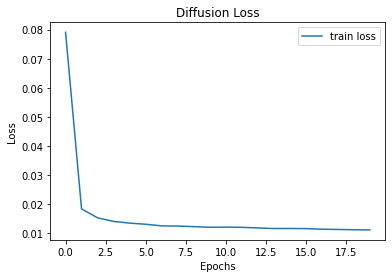


 Evaluating...


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

generated images IS_score:


Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

(3.680487160875174, 0.0)


In [ ]:
df = Diffusion(schedule=linear_beta_schedule, timesteps=1000, loss_type="huber")
train(num_epochs=20, diffusion_model=df, timesteps=1000, plot=True, name='og', eval=True)

### Testing

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
image_size = 28
channels = 1

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


model = Unet(
    dim=image_size,
    channels=channels,
    dim_mults=(1, 2, 4,)
)
model.to(device)


path = 'model_checkpoint_20.pth'
checkpoint = torch.load(path)
model.load_state_dict(checkpoint['model_state_dict'])


evaluate_num = 1000

# make the gen data set and folder
gen_set = []


with torch.no_grad():
    fake_batch = df.sample(model, image_size=image_size, batch_size=evaluate_num, channels=channels)

  
    for i in range(evaluate_num):
      gen_image = fake_batch[i].cpu().detach()
      gen_image = gen_image.reshape(-1,28,28).unsqueeze(0)
      gen_image = gen_image.repeat(1,3,1,1)
      gen_set.append(gen_image)

gen_set = TensorDataset(torch.cat(gen_set))

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
test_batch_size = 1
test_dataset = datasets.FashionMNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=test_batch_size, shuffle=True)

In [ ]:
# Prepare the torch dataset
evaluate_num = 1000
real_set = []

for idx, data in enumerate(test_loader, 0):
    
    image = data[0]
    image = image.repeat(1,3,1,1)
    
    real_set.append(image)

    if idx == evaluate_num-1:
        break

# make the pytorch dataset
real_set = TensorDataset(torch.cat(real_set))

In [ ]:
from inception_score import inception_score
import warnings
warnings.filterwarnings("ignore")


print('real images IS_score:')
print(inception_score(real_set, cuda=True, batch_size=64, resize=True, splits=1))

print('generated images IS_score:')
print(inception_score(gen_set, cuda=True, batch_size=64, resize=True, splits=1))

real images IS_score:
(4.0885181993937065, 0.0)
generated images IS_score:
(4.18422166323025, 0.0)


## Qualitative Visualisations 

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the model
model = Unet(
    dim=28,
    channels=1,
    dim_mults=(1, 2, 4,)
)
model.to(device)

path = 'model/model_checkpoint_og.pth'
checkpoint = torch.load(path)
model.load_state_dict(checkpoint['model_state_dict'])
print("Checkpoint loaded at epoch {}".format(checkpoint['epoch']))

Checkpoint loaded at epoch 20


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

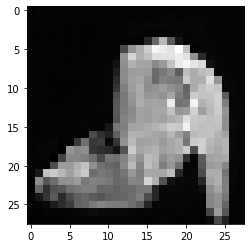

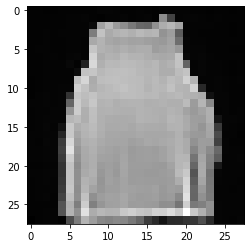

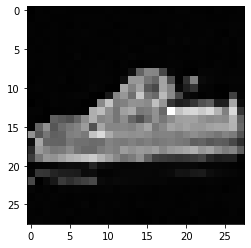

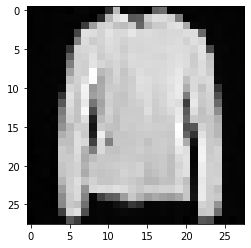

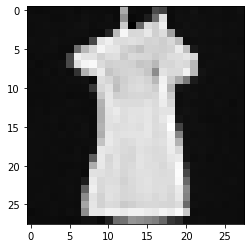

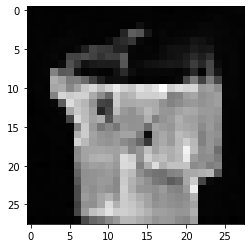

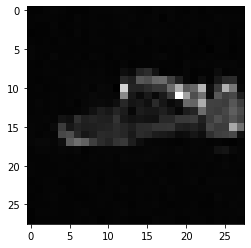

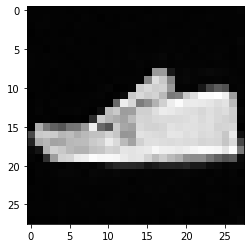

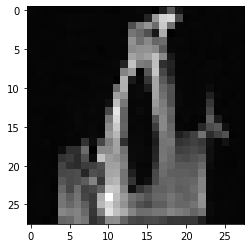

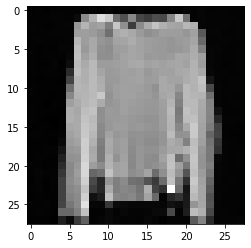

In [ ]:
# sample 10 images and plot
samples = df.sample(model, image_size=28, batch_size=10, channels=1)

for i in range(10):
  plt.imshow(samples[i].permute(1, 2, 0)[:, :, 0].numpy(), cmap='gray')
  plt.show()

## Ablation Study

l1 <function linear_beta_schedule at 0x7fbe2ef9e040>


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 1, Loss: 0.2191


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 2, Loss: 0.0930


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 3, Loss: 0.0818


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 4, Loss: 0.0757


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 5, Loss: 0.0731


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 6, Loss: 0.0711


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 7, Loss: 0.0686


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 8, Loss: 0.0683


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 9, Loss: 0.0672


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 10, Loss: 0.0660


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 11, Loss: 0.0652


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 12, Loss: 0.0655


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 13, Loss: 0.0645


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 14, Loss: 0.0630


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 15, Loss: 0.0623


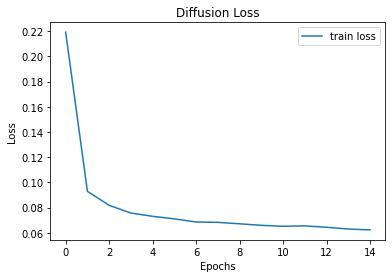


 Evaluating...


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

generated images IS_score:
(3.3707254362007673, 0.0)




l1 <function cosine_beta_schedule at 0x7fbe2ef8ad30>


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 1, Loss: 0.2322


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 2, Loss: 0.1292


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 3, Loss: 0.1189


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 4, Loss: 0.1126


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 5, Loss: 0.1089


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 6, Loss: 0.1070


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 7, Loss: 0.1042


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 8, Loss: 0.1018


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 9, Loss: 0.1012


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 10, Loss: 0.1005


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 11, Loss: 0.0993


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 12, Loss: 0.0977


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 13, Loss: 0.0971


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 14, Loss: 0.0965


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 15, Loss: 0.0958


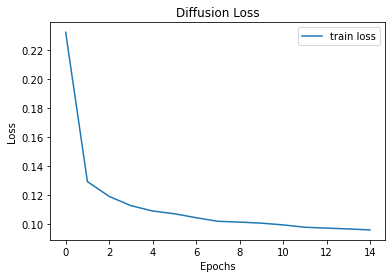


 Evaluating...


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

generated images IS_score:
(1.6140068170795925, 0.0)




l1 <function quadratic_beta_schedule at 0x7fbe2ef9e4c0>


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 1, Loss: 0.2299


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 2, Loss: 0.1214


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 3, Loss: 0.1105


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 4, Loss: 0.1045


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 5, Loss: 0.1009


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 6, Loss: 0.0986


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 7, Loss: 0.0969


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 8, Loss: 0.0942


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 9, Loss: 0.0936


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 10, Loss: 0.0916


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 11, Loss: 0.0906


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 12, Loss: 0.0897


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 13, Loss: 0.0888


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 14, Loss: 0.0887


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 15, Loss: 0.0876


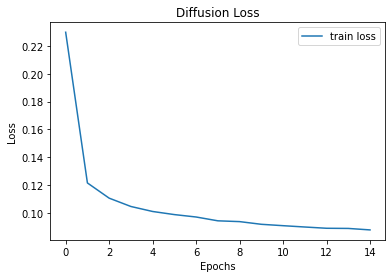


 Evaluating...


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

generated images IS_score:
(3.6521086731110204, 0.0)




l1 <function sigmoid_beta_schedule at 0x7fbe2ef9ef70>


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 1, Loss: 0.2339


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 2, Loss: 0.1246


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 3, Loss: 0.1124


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 4, Loss: 0.1064


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 5, Loss: 0.1012


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 6, Loss: 0.0987


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 7, Loss: 0.0970


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 8, Loss: 0.0944


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 9, Loss: 0.0939


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 10, Loss: 0.0920


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 11, Loss: 0.0909


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 12, Loss: 0.0905


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 13, Loss: 0.0897


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 14, Loss: 0.0885


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 15, Loss: 0.0878


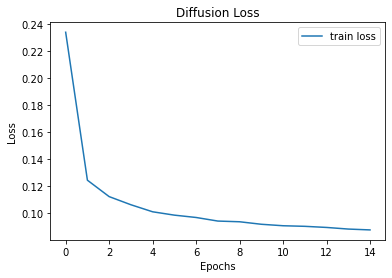


 Evaluating...


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

generated images IS_score:
(3.3040410334045105, 0.0)




l2 <function linear_beta_schedule at 0x7fbe2ef9e040>


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 1, Loss: 0.1655


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 2, Loss: 0.0419


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 3, Loss: 0.0362


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 4, Loss: 0.0325


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 5, Loss: 0.0299


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 6, Loss: 0.0282


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 7, Loss: 0.0271


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 8, Loss: 0.0271


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 9, Loss: 0.0264


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 10, Loss: 0.0257


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 11, Loss: 0.0259


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 12, Loss: 0.0254


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 13, Loss: 0.0254


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 14, Loss: 0.0250


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 15, Loss: 0.0243


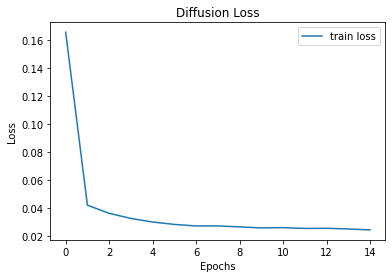


 Evaluating...


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

generated images IS_score:
(3.380880657196319, 0.0)




l2 <function cosine_beta_schedule at 0x7fbe2ef8ad30>


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 1, Loss: 0.2263


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 2, Loss: 0.0703


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 3, Loss: 0.0599


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 4, Loss: 0.0540


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 5, Loss: 0.0513


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 6, Loss: 0.0493


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 7, Loss: 0.0484


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 8, Loss: 0.0475


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 9, Loss: 0.0470


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 10, Loss: 0.0462


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 11, Loss: 0.0454


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 12, Loss: 0.0448


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 13, Loss: 0.0451


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 14, Loss: 0.0442


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 15, Loss: 0.0438


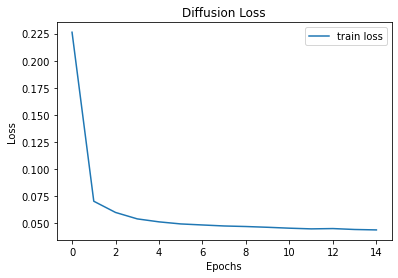


 Evaluating...


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

generated images IS_score:
(2.607897357391346, 0.0)




l2 <function quadratic_beta_schedule at 0x7fbe2ef9e4c0>


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 1, Loss: 0.1950


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 2, Loss: 0.0602


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 3, Loss: 0.0526


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 4, Loss: 0.0485


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 5, Loss: 0.0463


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 6, Loss: 0.0441


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 7, Loss: 0.0437


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 8, Loss: 0.0428


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 9, Loss: 0.0422


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 10, Loss: 0.0415


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 11, Loss: 0.0411


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 12, Loss: 0.0408


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 13, Loss: 0.0404


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 14, Loss: 0.0406


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 15, Loss: 0.0405


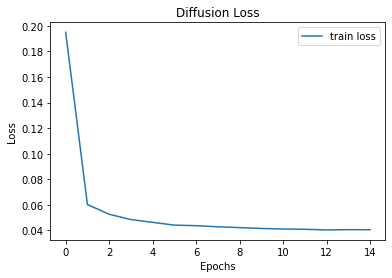


 Evaluating...


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

generated images IS_score:
(3.459249407594748, 0.0)




l2 <function sigmoid_beta_schedule at 0x7fbe2ef9ef70>


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 1, Loss: 0.2504


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 2, Loss: 0.0675


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 3, Loss: 0.0591


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 4, Loss: 0.0549


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 5, Loss: 0.0519


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 6, Loss: 0.0502


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 7, Loss: 0.0488


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 8, Loss: 0.0484


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 9, Loss: 0.0465


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 10, Loss: 0.0465


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 11, Loss: 0.0457


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 12, Loss: 0.0455


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 13, Loss: 0.0448


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 14, Loss: 0.0446


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 15, Loss: 0.0443


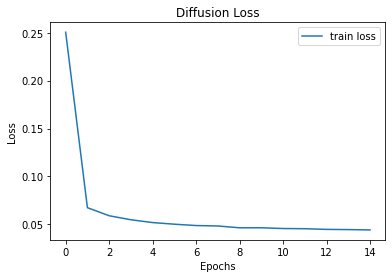


 Evaluating...


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

generated images IS_score:
(3.383323285425501, 0.0)




huber <function linear_beta_schedule at 0x7fbe2ef9e040>


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 1, Loss: 0.0609


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 2, Loss: 0.0182


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 3, Loss: 0.0152


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 4, Loss: 0.0143


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 5, Loss: 0.0136


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 6, Loss: 0.0129


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 7, Loss: 0.0128


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 8, Loss: 0.0123


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 9, Loss: 0.0123


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 10, Loss: 0.0120


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 11, Loss: 0.0118


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 12, Loss: 0.0121


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 13, Loss: 0.0118


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 14, Loss: 0.0116


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 15, Loss: 0.0117


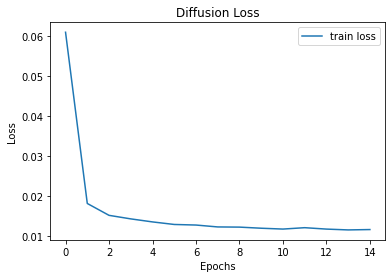


 Evaluating...


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

generated images IS_score:
(3.450361599348186, 0.0)




huber <function cosine_beta_schedule at 0x7fbe2ef8ad30>


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 1, Loss: 0.0992


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 2, Loss: 0.0318


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 3, Loss: 0.0270


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 4, Loss: 0.0250


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 5, Loss: 0.0241


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 6, Loss: 0.0232


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 7, Loss: 0.0228


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 8, Loss: 0.0223


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 9, Loss: 0.0222


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 10, Loss: 0.0220


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 11, Loss: 0.0216


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 12, Loss: 0.0213


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 13, Loss: 0.0211


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 14, Loss: 0.0211


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 15, Loss: 0.0209


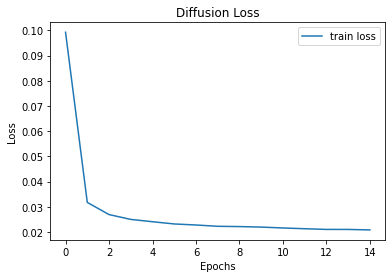


 Evaluating...


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

generated images IS_score:
(2.1523664201415778, 0.0)




huber <function quadratic_beta_schedule at 0x7fbe2ef9e4c0>


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 1, Loss: 0.0942


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 2, Loss: 0.0285


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 3, Loss: 0.0242


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 4, Loss: 0.0227


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 5, Loss: 0.0215


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch: 6, Loss: 0.0212


  0%|          | 0/469 [00:00<?, ?batch/s]

In [ ]:
losses = ['l1', 'l2', 'huber']
schedules = [linear_beta_schedule, cosine_beta_schedule, quadratic_beta_schedule, sigmoid_beta_schedule]

k = 0
for l in losses:
  for s in schedules:
    print(l, s)
    df = Diffusion(schedule=s, timesteps=1000, loss_type=l)
    train(num_epochs=15, diffusion_model=df, timesteps=1000, plot=True, name=str(k), eval=True)
    print("\n")
    print("\n")
    k = k + 1